# Ensembles, Bagging and Random Forests
<br>
### Wisdom of the Crowds
<br>
#### Jonathan Ng 
###### (adapted from Cary Goltermann (mostly), Ivan Corneillet and Scott Schwartz)

# Objectives

* Review Decision Trees
* Intro to Ensembles
* Bootstrap Aggregating
* Out of Bag (OOB) Error
* Random Forests

# Intro to Ensembles

Ensembling: building a prediction model by combining the strength of a collection of more simple base models.

Can be broken down into two basic steps:
1. Training a set of base learners (can be different types of learners)
2. Combine the base learners into a composite model

# Steps for Committee Ensemble

1. Train many base models separate from one another
2. The composite model is made by allowing each of the base models to vote on the prediction. For regression, the average of these votes is taken as the ensemble's prediction. For classification, the majority vote.

# Wisdom of the Crowd

Suppose you are trying to predict an election

* You have 5 experts
* Each expert was picked INDEPENDENTLY of the others
* Each expert has a 70% chance of being right


1. How can we leverage the expert picks to improve accuracy you would be right?

2. How many independent predictors would you need to have a 99.9% probability of being correct?

![million](img/million.png)



# Wisdom of the Crowd

1. We can take use an ensemble method! (see title of slide)
    * need only 3 individuals (of 5) to be correct
    * increases accuracy to 83.7%
    
![experts_calculation](img/experts_calculation.png)
    
2. With 101 such experts, we can achieve a 99.9% majority vote accuracy. (exercise left to the reader)

It's clear that utilizing multiple weak classifiers can yield a very strong classifier! (Whoa!)
The overall prediction is better than any one model (expert) could do its own.


# Decision Trees

A frequent choice for the base learner in ensembles, lets recall what they look visually.

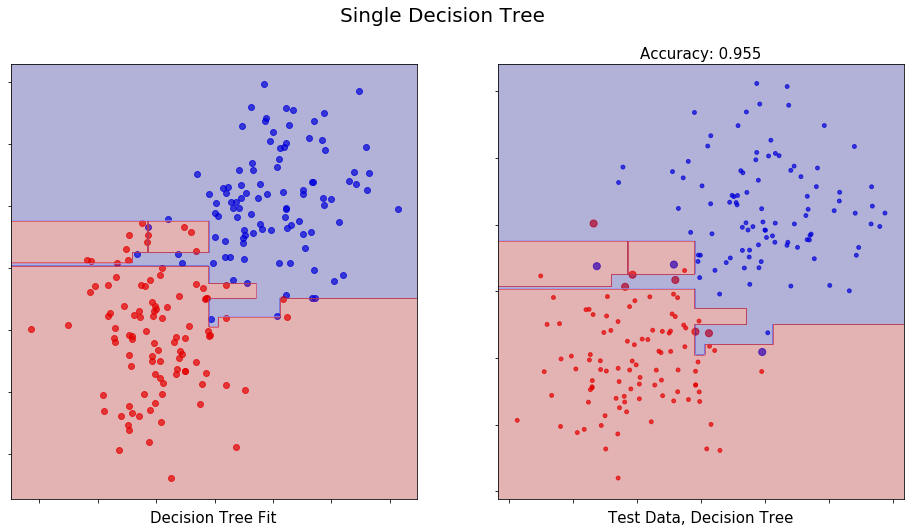

In [1]:
from random_forest_viz import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

X, y = make_data(n_points=100, state=3)
X_test, y_test = make_data(n_points=100, state=5)
plot_one_tree(X, y, X_test, y_test)

# Decision Tree Review
<br>

## Individual Questions (2 mins)

1. How are splits in a decision tree decided?
2. Are decision trees a high/low bias or high/low variance?
3. How can we control the bias/variance in a decision tree?

## Discuss answers in pairs (3 mins)

#### Answers

1. Choosing the split that minimizes Gini/Entropy -> Information Gain for classification and MSE -> Information Gain for regression.
2. They can be either high bias - low variance or low bias - high variance depending on how deep you grow them.
3. We prune them, either
    * pre: decide hyperparameters like min leaf size or max depth, or
    * post: assign a penality for adding a new node and find the optimal number of nodes with cross validation.


# Committee Ensembling Decision Trees

Following the steps of committee ensembling, to make an ensemble of trees we:
1. Train many decision trees separate from each other
2. To predict we make a prediction with each of the above models and then take the average of that as our ensemble prediction

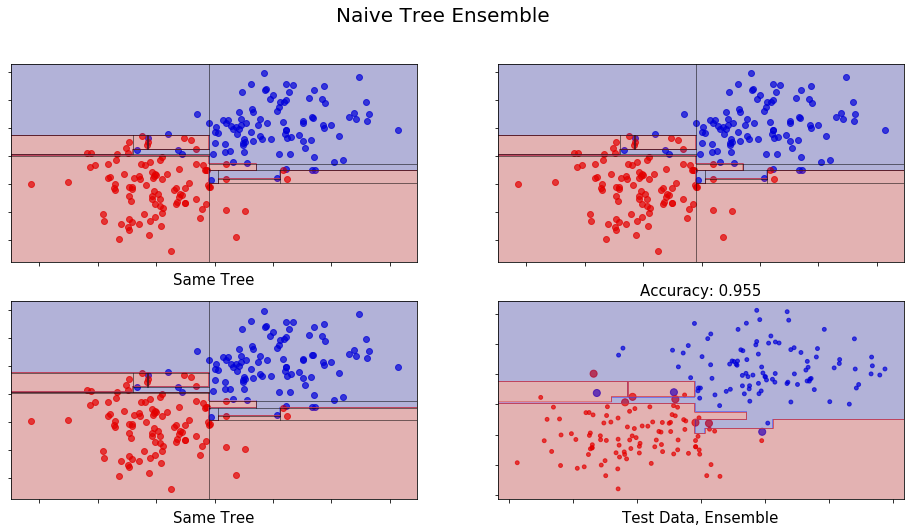

In [2]:
plot_naive_tree_ensemble(X, y, X_test, y_test)

<center>What do you notice about the decision boundary for the ensemble?</center>

# Naive Ensemble: FAIL!

The decision boundary for the ensemble is exactly the same as that of a single tree in the ensemble!

I thought this ensemble thing we just learned was magic... why does said magic not apply here?

What are we to do then?

# Ensembles of Decision Trees

* Independence!
* We could repeatedly sample from the population, building decision tree models and averaging the results. Unfortunately, we only have one sample, and if all the learners are exactly the same (and not independent), creating an ensemble model won't help

## Pair Question (2 mins)

What could we do to our trees/data to make it so that we don't get the same for each one in the ensemble?

* Solution: train each learner on a different subset of the data
    * Problem: How do we do this when we only have one set of data to work with??

#### Answer

We could sample from our data for each tree we build. What sampling method should we use?? How about bootstrapping?!

# Bootstrap Review
<br>

## Individual Questions
1. Describe the process of bootstrapping in your own words?
2. Describe what the bootstrap is used for?

## Discuss answers in pairs (2 mins)

#### Answers

1. Randomly sample with replacement from the training sample a new sample with the same size as the true sample.
2. Create a distribution of point estimates, each created from a single bootstrapped sample, with this distribution we can create confidence bounds on the point estimates. | We used bootstrap samples to construct confidence intervals around a sample statistic


# Bootstrapping

Method:
* Start with dataset of size n
* Sample from dataset **with replacement** to create one bootstrap sample of size n
* Repeat B times
* Each bootstrap sample can then be used as a separate dataset for estimation or model fitting

Previously we used the bootstrap to assess the accuracy of a parameter estimate.
* e.g. the population mean from which we drew a data sample

<br>

#### Now we describe a way to use the bootstrap to improve a prediction!

<h1><span style="color:blue">B</span>ootstrap <span style="color:blue">Agg</span>rat<span style="color:blue">ing</span>: Bagging</h1>

# Bagged Decision Trees

Following the steps of committee ensembling, now adding the bootstrap to the mix, to make an ensemble of trees we:
1. Train many decision trees separate from each other each by this process:  
      1\. Take a bootstrap sample of your training data  
      2\. Train a single decision tree to the bootstrap sample
2. To predict we make a prediction with each of the above models and then take the average (regression) or majority vote (classification) of that as our ensemble prediction

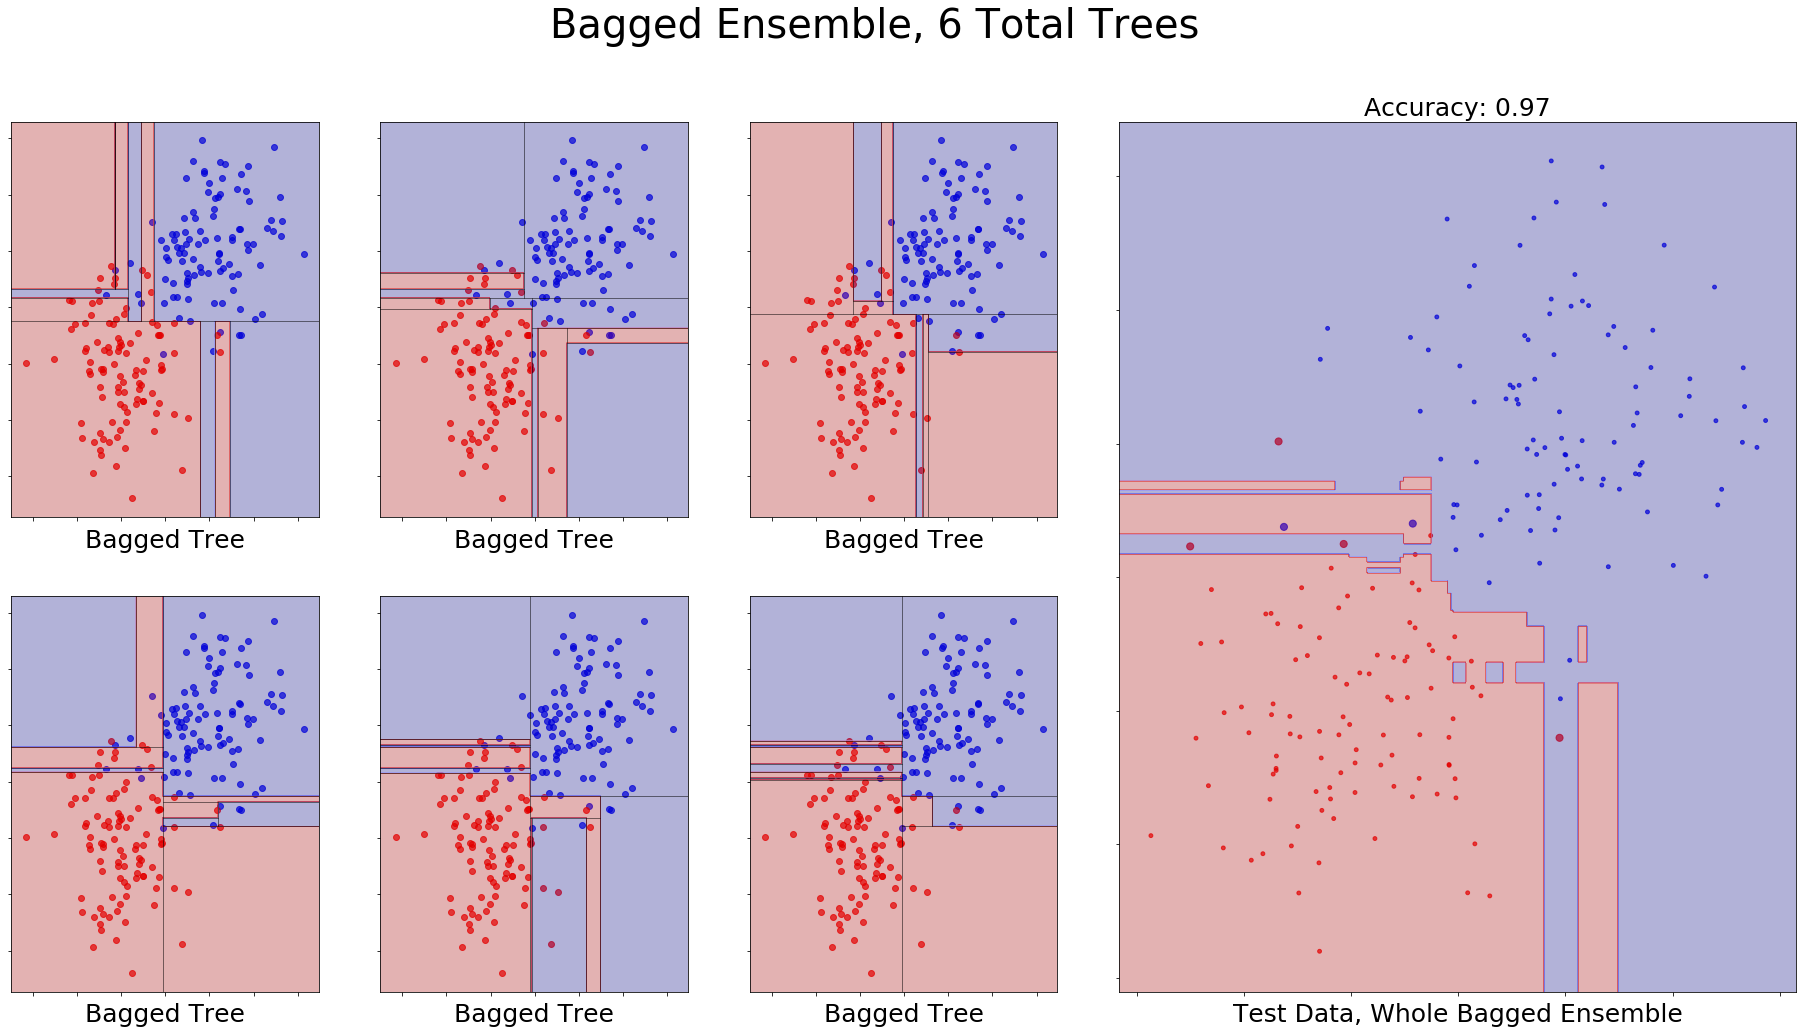

In [3]:
plot_tree_ensemble(X, y, X_test, y_test, only_bagging=True)

# Why Bagging Works

* Let $\hat{f}^{(j)}(x_0)$ be the $j^{th}$ predictor of outcome $f(x_0)$ constructed from a training set with features $x^{(j)}$ and targets $y^{(j)}$.
* If each $\hat{f}^{(j)}(x_0)$ is an unbiased predictor of $f(x_0)$ then:
    $$ E\bigg[ \frac1B \sum_{j=0}^B \hat{f}^{(j)}(x_0) \bigg]  = \hat{f}_{bag}(x_0) \approx f(x_0), $$
or in english, the expectation of the average of unbiased predictors of a function is the true function.

# Bias

![bias](img/bias.png)

# Variance Averaging

![variance](img/variance.png)

* (**) Assuming that predictors $\hat{f}^{(j)}$ are independent from each other, so no covariance terms
    
* So even if $\hat{f}^{(j)}(x_0)$ is a high variance predictor, the variance of the <span style="color:blue">averaged</span> predictor $\hat{f}_{bag}(x_0) = \frac1B \sum_{j=0}^B \hat{f}^{(j)}(x_0)$ decreases with $B$.

# Tree Bagging

* Bagging is a general-purpose procedure for reducing the vairance of a statistical learning method
* Therefore, bagging is simply predicting $f(x_0)$ with $ \hat{f}_{bag}(x_0) = \frac1B \sum_{j=0}^B \hat{f}^{(j)}(x_0)$, <span style="color:blue">an average of predictors made from bootstrapped samples</span> where:
    * $(x^{(j)}, y^{(j)})$ is the $j^{th}$ bootstrapped sample, and 
    * $\hat{f}^{(j)}(x_0)$ is the $j{th}$ model fit to its corresponding bootstrapped sample.
* Bootstrapped trees provide unbiased, high variance predictors.
* Averaged, ensembled, models are lower variance than single predictors in addition to maintaining the bias of a single tree, 0, i.e., the ensemble is unbiased.
* The number of trees B is not a critical parameter with bagging; using a very large B won't lead to overfitting.
    * Want to use a large enough B such that the test error has settled down

# Bagging Intuition

The process of bagging:
* explores the "data set"/"feature" space, then uses average to predict what we might see under different sampling
* grows trees that each have a slightly different view of the data and then averages together their collective understanding of the data

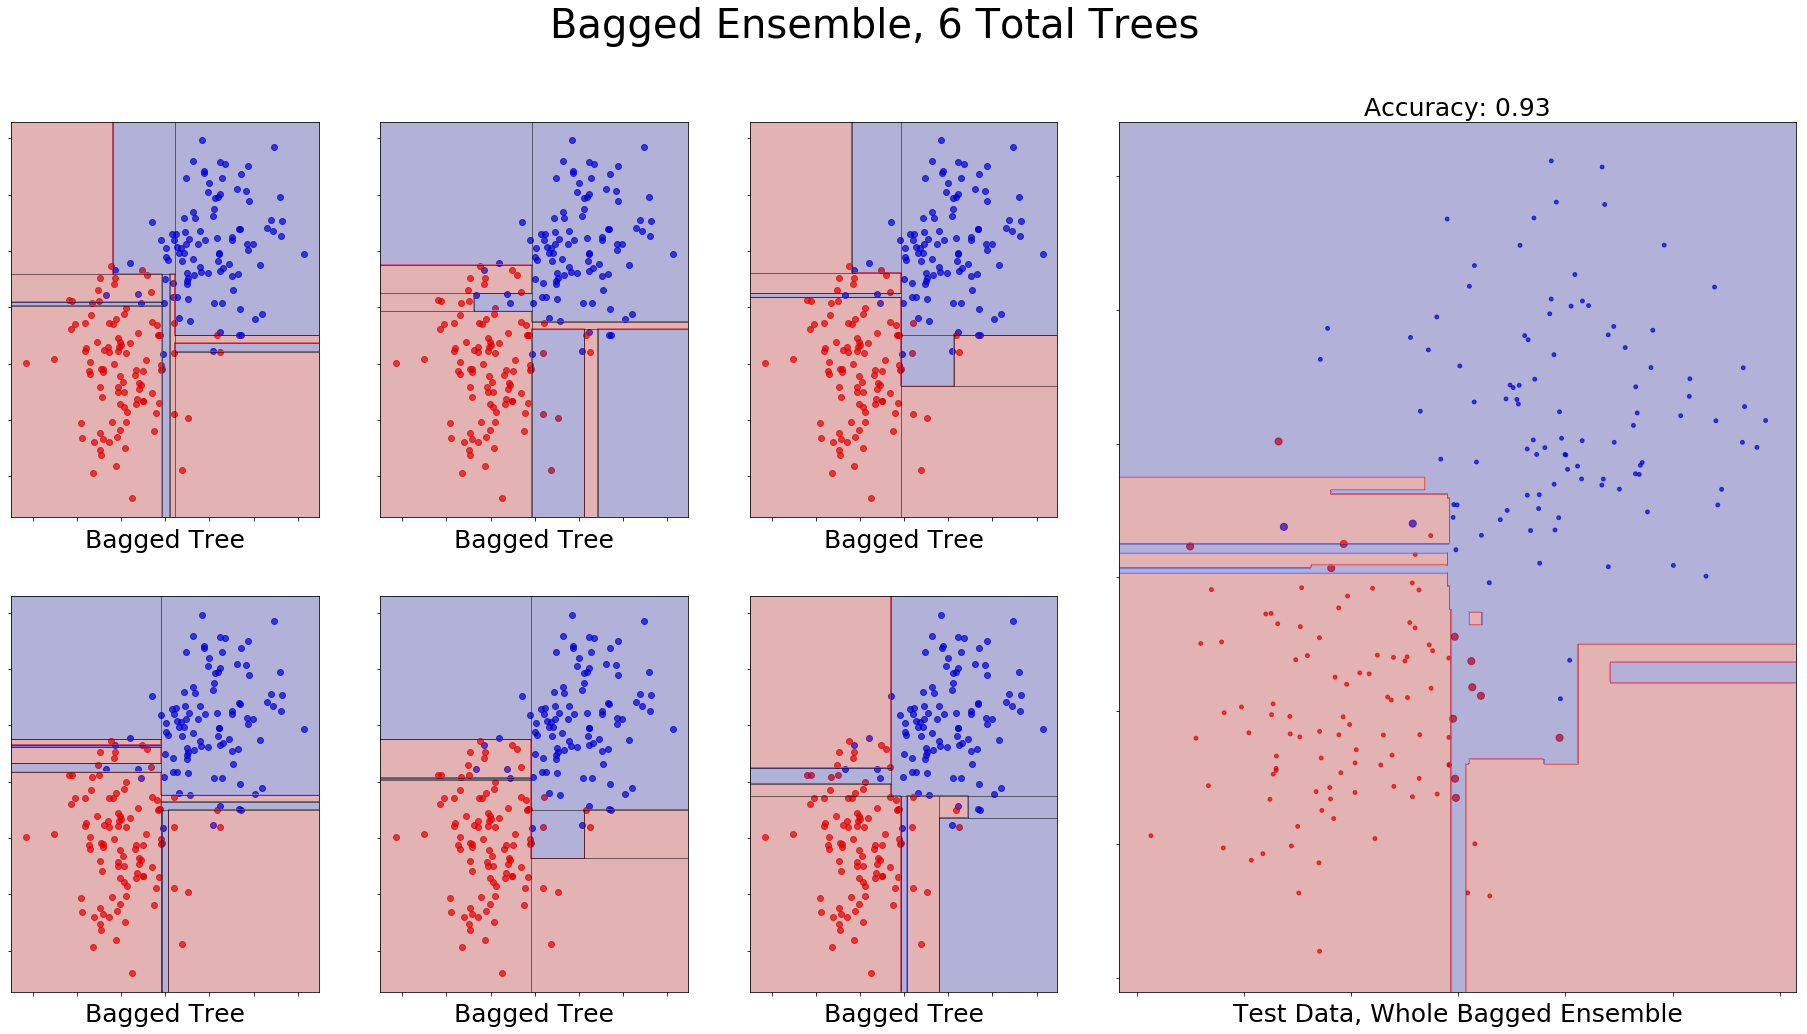

In [4]:
plot_tree_ensemble(X, y, X_test, y_test, only_bagging=True)

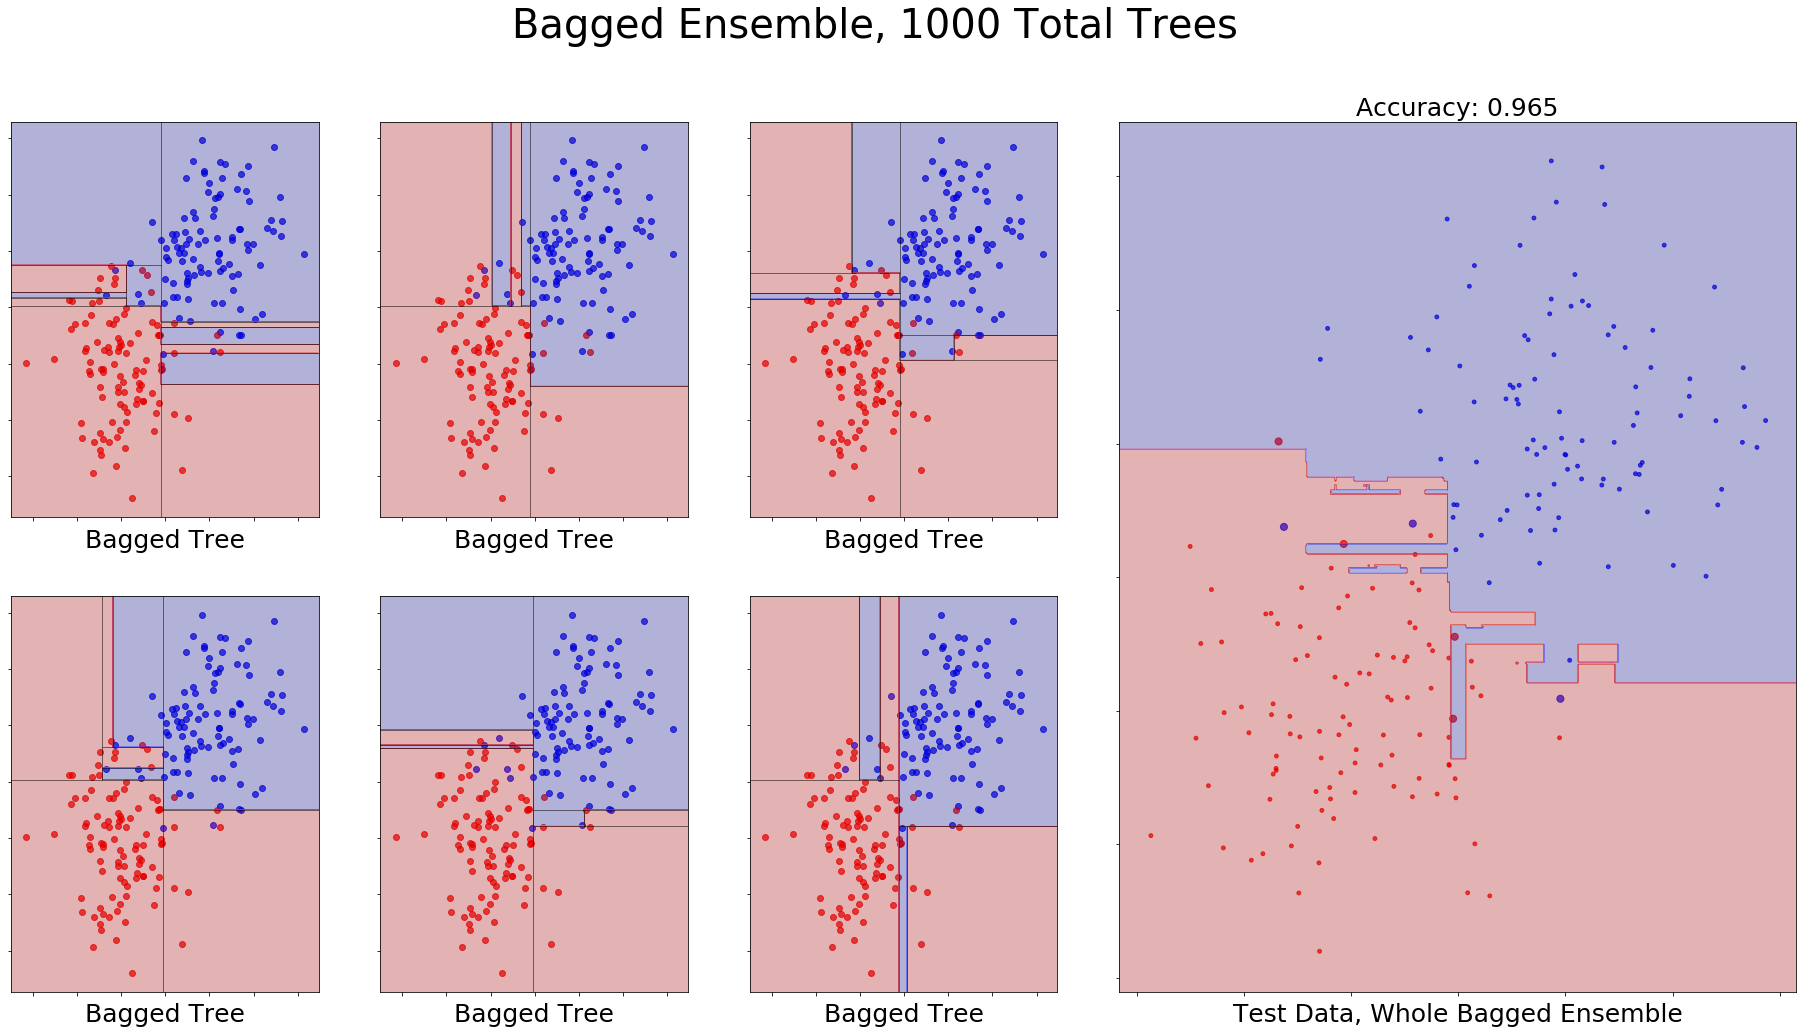

In [5]:
plot_tree_ensemble(X, y, X_test, y_test, only_bagging=True, n_estimators=1000, n_jobs=-1)

# Out of Bag (OOB) Error

There is an interesting aspect of using the bootstrap that we can exploit to estimate the test error for our bagged model.

* On average, each bagged tree makes use of ~$\frac23$ (really it's $1-\frac{1}{e}$) of the observations
* The remaining ~$\frac13$ observations not used to fit a given bagged tree are referred to as the out-of-bag (OOB) observations
* Predict response for the $i$th observation using each tree in which that observation was OOB (~$\frac{B}3$) predictions for ith observation averaged
* For large B, this estimate is essentially the LOO cross-validation error for bagging (empirical)
* Cross-validation can be computationally demanding; still need it for methodology comparisons (since OOB doesn't exist in other model fitting contexts)


# Oops

$$ Var\bigg[ \sum_{j=0}^B \frac1B \hat{f}^{(j)}(x_0) \bigg] \ne \frac{\sigma^2}B !!!$$

#### What is it actually then?

$$ \begin{align}
        Var[X + Y] &= Var[X] + Var[Y] + \color{red}{2*Cov[X, Y]} \\
        Var\big[\hat{f}^{(j)}(x_0) + \hat{f}^{(k)}(x_0)\big] &= Var\big[\hat{f}^{(j)}(x_0)\big] +
                                                                Var\big[\hat{f}^{(k)}(x_0)\big]\; + \\ 
                                                             & \qquad \color{red}{2*Cov\big[\hat{f}^{(j)}(x_0),
                                                                                     \hat{f}^{(k)}(x_0)\big]}
   \end{align}$$
   
* Before we assumed that $\hat{f}^{(j)}$ and $\hat{f}^{(k)}$ were independent to get to $\frac{\sigma^2}B$ ... are they independent??

# Are Our Trees Correlated??

Well...
* $\hat{f}^{(j)}(x_0)$ is fit on $(x^{(j)}, y^{(j)})$
* $\hat{f}^{(k)}(x_0)$ is fit on $(x^{(k)}, y^{(k)})$

* $x^{(j)}, x^{(k)}$ are both bootstrapped from *the same* $\textbf{X}$ sample
* $y^{(j)}, y^{(k)}$ are both bootstrapped from *the same* $\textbf{y}$ sample

* They are very similar samples, they certainly overlap, their influential features tend to be the same, and therefore
* We expect $\hat{f}^{(j)}(x_0)$ and $\hat{f}^{(y)}(x_0)$ to be correlated!

# How Good is Bagging Then?

If we say: $Cor[\hat{f}^{(j)}(x_0), \hat{f}^{(k)}(x_0)] = \rho, $ for all $j$ and $k$ then:

<br>
    $$ Var\bigg[ \sum_{j=0}^m \frac1m \hat{f}^{(j)}(x_0) \bigg] = \rho \sigma^2 + (1-\rho)\frac{\sigma^2}m $$

* So only the uncorrelated parts of the trees get the benefit of averaging variance.
* We want $\rho$ to be close to 0

# Random Forests
<br>
### And the Quest to Get Zero Tree Correlation

* Like bagging, random forests use the bootstrap to average away some of the variance in our high variance, low bias models.
* But, they go one step beyond the bootstrap to help decorrelate our base models, make $\rho$ smaller.

# Let's Put the Random In Random Forests

* Trees are correlated because:
    1. bootstrap samples are about the same (can't do anything about this...)
    2. influential features tend to be the same (this we could influence...)
* The extra decorrelation between the trees of a random forest is achieved by exploiting an intriguing quality of the trees: that their "parameters" are the splits that individually only need knowledge of a single feature at a time.
* To take advantage of this property of trees, **each split** in **each tree** of a random forest only see's a subset of the features when it's making it's split.

# Random Forest Decision Trees

Following the steps of bootstrap committee ensembling, now adding the random feature selection to the mix, to make an ensemble of trees we:
1. Train many decision trees separate from each other each by this process:  
      1\. Take a bootstrap sample of your training data  
      2\. Train a single decision tree to the bootstrap sample by the regular process except that: **at each node** only consider a **subset of features** to split on.
2. To predict we make a prediction with each of the above models and then take the average of that as our ensemble prediction

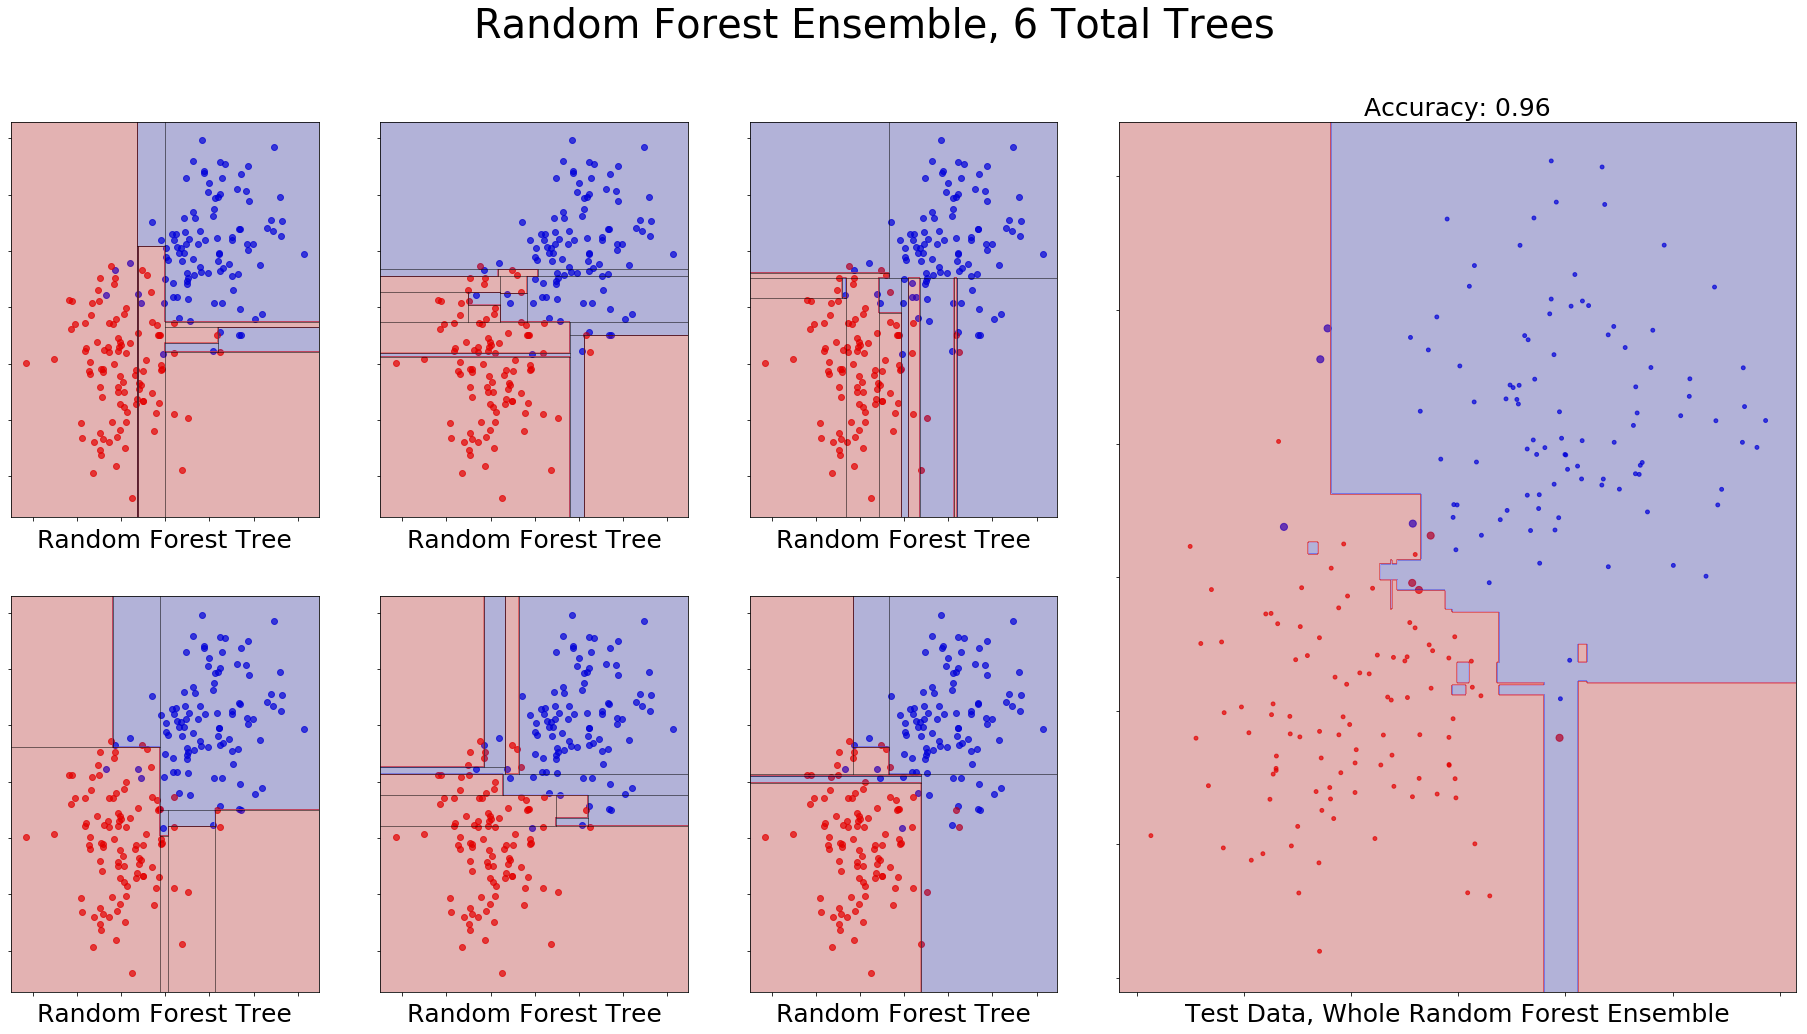

In [6]:
plot_tree_ensemble(X, y, X_test, y_test)

# Random Forest Intuition

Beyond bagging, the process of random feature selection:
* forces trees to split on features with might not be the "**best**";
* this quality, in aggregate, allows the ensemble to find a more generalizable trend in the data.

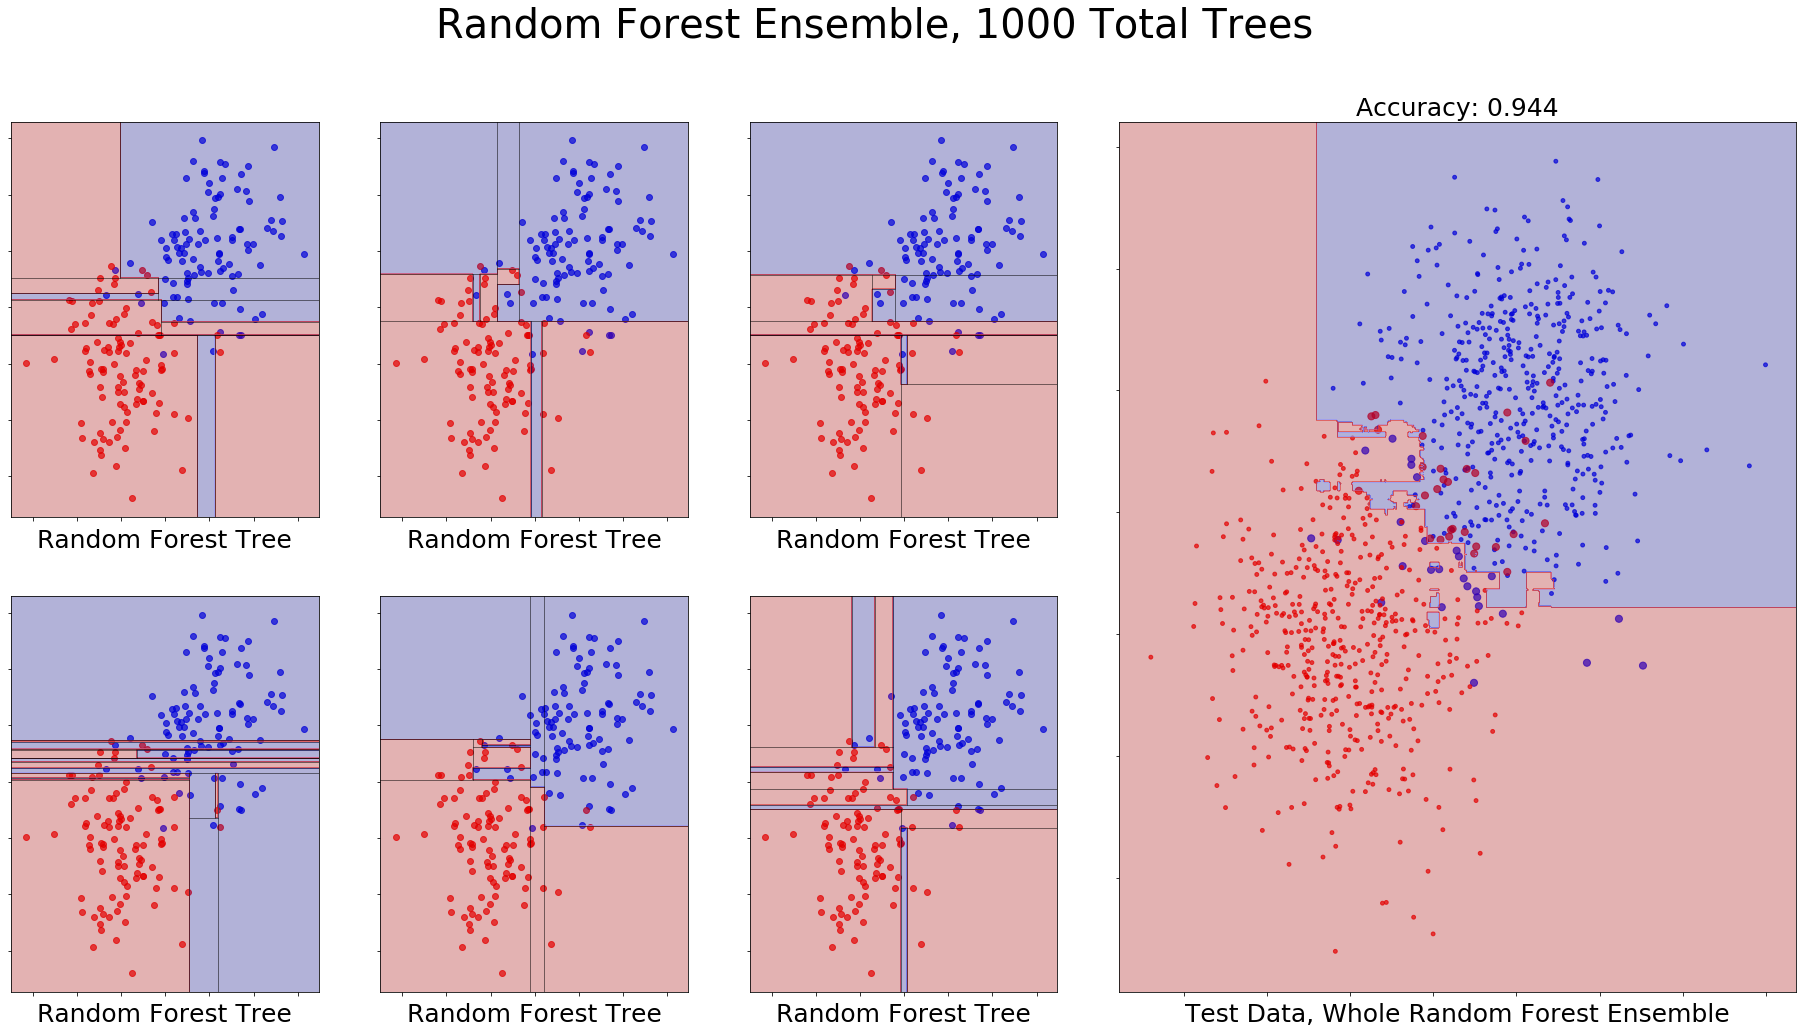

In [7]:
X_test_large, y_test_large = make_data(n_points=500, state=7)
plot_tree_ensemble(X, y, X_test_large, y_test_large, n_estimators=1000, n_jobs=-1)

# Random Forest Tuning

* $m$: number of features we consider at each split
    * $ m = \sqrt{p} $ for classification
    * $ m = \frac{p}3 $ for regression    
    * as $m$ increases, our trees become more correlated; has bias-variance tradeoff
* $B$: number of trees (i.e., number of bootstrapped samples)
* $n_b$: sample size of each bootstrapped sample
* Individual tree characteristics (ex: max_depth)
    * RFs are often robust to tree characteristics; very large numbers of "bushy" trees are typically used and approach state of the art performance out of the box

# Random Forests

### Pros
* Often gives near state-of-the-art performance
* Good out-of-the-box performance
* No feature scaling needed
* Model nonlinear relationships

### Cons
* Can be expensive to train (though can be done in parallel)
* Models can be quite large (the pickled version of a several hundred tree model can easily be several GBs)
* Not interpretable (generally)

# Review
* What are ensembles and what are they good for?
* What is bootstrapping?
* Describe how bagging works and what it accomplishes (how does it improve on, say, a naive ensemble of decision trees?)?
* What is the Out of Bag (OOB) Error and why is it useful? When is it not useful?
* How do Random Forests differ from bagging and what does it accomplish (how does it improve on bagging?)?